In [1]:
from boututils.datafile import DataFile
from boutdata.collect import collect
from boutdata.data import BoutData
import os, sys
import matplotlib

import matplotlib.pyplot as plt
import xbout
import pandas as pd
import numpy as np
import xarray as xr

from boutdata.restart import addvar
import glob
import shutil
import scipy
import netCDF4 as nc

sys.path.append(r"/home/mike/work/sdtools")


from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.neutral_transport import NeutralTransport
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
from hermes3.balance1d import *
from hermes3.selectors import *

from hermes3.utils import *
# from code_comparison.code_comparison import *

%load_ext autoreload
%autoreload 2

In [2]:
db = CaseDB(
    case_dir = r"/home/mike/work/cases",
    grid_dir = r"/home/mike/work/cases"
    )

In [3]:
toload = [ 
    dict(name="test", id="targetpump_allpump", unnormalise = True), 
    # dict(name="base", id="targetpump_base_from_2Dprod", unnormalise = True), 

]
cs = {}
for case in toload:
    cs[case["name"]] = db.load_case_2D(case["id"], use_squash = False, verbose = True, unnormalise = case["unnormalise"], unnormalise_geom = case["unnormalise"])
    cs[case["name"]].extract_2d_tokamak_geometry()


/home/mike/work/boutdata/src/boutdata/data.py:761: AlwaysWarning: While building x, y, z coordinate arrays, an exception occured: [Errno 2] No such file or directory: '"grid_test2_allpump.nc"'
Evaluating non-scalar options not available
  alwayswarn(


- Reading case targetpump_allpump
-----------------------


/home/mike/work/xbout/xbout/load.py:1129: UserWarning: Will drop all variables containing the dimensions 't' because they are not recognised
  warn(



Unnormalising with xHermes


# Reproduce pump

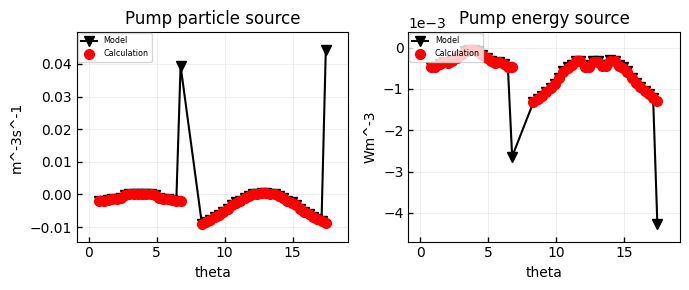

In [4]:
ds = cs["test"].ds.load()
if "t" in ds.sizes:
    ds = ds.isel(t=-1)
    
options = ds.options
q_e = constants("q_e")

sol_multiplier = options["d+"]["sol_recycle_multiplier"]
sol_fast_recycle_energy_factor = 0.0
sol_fast_recycle_fraction = 0.0
sol_energy = options["d+"]["sol_recycle_energy"] * q_e
pump_multiplier = options["d+"]["pump_recycle_multiplier"]

m = ds.metadata
# q_e = constants("q_e")
# Mi = constants("mass_p") * 2


Td = ds["Td"].values / m["Tnorm"]
Nd = ds["Nd"].values / m["Nnorm"]
dl = ds["dl"] / m["rho_s0"]
dtor = ds["dtor"] / m["rho_s0"]
dv = ds["dv"] / (m["rho_s0"]**3)
ion_particle_flow = (ds["pfd+_tot_xlow"].isel(x=-2)) / ds["pfd+_tot_xlow"].attrs["conversion"]
ion_heat_flow = (ds["efd+_tot_xlow"].isel(x=-2)) / ds["efd+_tot_xlow"].attrs["conversion"]

Mi = 2
q_e = 1


### Recycling
# Particles
recycle_particle_flow = ion_particle_flow * sol_multiplier

# Heat
fast_bit = ion_heat_flow * sol_multiplier * sol_fast_recycle_fraction * sol_fast_recycle_energy_factor 
thermal_bit = ion_particle_flow * sol_multiplier * (1-sol_fast_recycle_fraction) * sol_energy
recycle_heat_flow = fast_bit + thermal_bit

### Neutral impingement
i = -3
g = -2
s = -4

tnguard = Td[i]**2 / Td[s] 
nnguard = Nd[i]**2 / Nd[s] 
nnsheath = 0.5 * (Nd[i] + nnguard)
tnsheath = 0.5 * (Td[i] + tnguard)
v_th = 0.25 * np.sqrt(8 * tnsheath * q_e / (np.pi * Mi))

dtorsheath = 0.5*(dtor[i] + dtor[g])
dlsheath = 0.5*(dl[i] + dl[g])
dasheath = dtorsheath * dlsheath

pump_neutral_particle_flow = v_th * nnsheath * dasheath
pump_neutral_particle_sink = pump_neutral_particle_flow / dv[i] * (1-pump_multiplier)

pump_neutral_energy_flow = 2.0 * tnsheath * v_th * nnsheath * dasheath 
pump_neutral_energy_sink = pump_neutral_energy_flow / dv[i] * (1-pump_multiplier)

### Totals
pump_density_source = recycle_particle_flow/dv - pump_neutral_particle_sink
pump_energy_source = recycle_heat_flow/dv - pump_neutral_energy_sink

norm = m["Nnorm"] * m["Omega_ci"]

edge = ds.isel(x=-3)
pump_theta = edge["theta"].where(edge["is_pump"]==1, drop = True).values

fig, axes = plt.subplots(1,2, figsize=(7,3), dpi = 100)
ax = axes[0]

sim_result = (edge["Sd_pump"] / edge["Sd_pump"].attrs["conversion"]).sel(theta=pump_theta)
calc_result = pump_density_source.isel(x=-3).sel(theta=pump_theta)

(sim_result).plot(ax = ax, label = "Model", marker = "v", ms = 7, c = "k",)
(calc_result).plot(ax = ax, label = "Calculation", marker = "o", lw = 0, ms = 7, c = "red")
ax.set_title("Pump particle source")
ax.set_ylabel("m^-3s^-1")

ax = axes[1]

sim_result = (edge["Ed_pump"] / edge["Ed_pump"].attrs["conversion"]).sel(theta=pump_theta)
calc_result = pump_energy_source.isel(x=-3).sel(theta=pump_theta)

(sim_result).plot(ax = ax, label = "Model", marker = "v", ms = 7, c = "k",)
(calc_result).plot(ax = ax, label = "Calculation", marker = "o", lw = 0, ms = 7, c = "red")
ax.set_title("Pump energy source")
ax.set_ylabel("Wm^-3")

for ax in axes:
    ax.grid()
    # ax.set_yscale("symlog")
    ax.legend(loc = "upper left", fontsize = "xx-small")

fig.tight_layout()


# Match upper target recycling

There is a bug: the heat flow only includes the sheath BC contribution to sheath heat flux


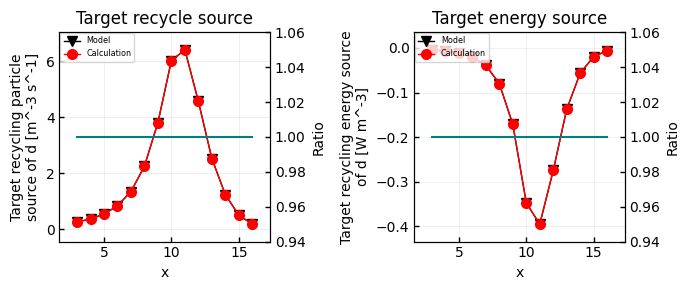

In [5]:
target_multiplier = options["d+"]["pump_recycle_multiplier"] # Pump overrides
# target_multiplier = options["d+"]["target_recycle_multiplier"]
target_energy = options["d+"]["target_recycle_energy"] / m["Tnorm"]
target_fast_recycle_fraction = options["d+"]["target_fast_recycle_fraction"]
target_fast_recycle_energy_factor = options["d+"]["target_fast_recycle_energy_factor"]

reg = ds.hermes.select_region("outer_lower_target").isel(x = slice(1,-1))
i = xhermes.slice_poloidal(ds, "outer_lower_target")
g = i + 1
xplot = reg["x"].values

x = slice(3,-3)  # Ignore edge cells because they have SOL and PFR recycling too


Ne = ds["Ne"].values / ds["Ne"].attrs["conversion"]
Vi = ds["Vd+"].values / ds["Vd+"].attrs["conversion"]
J = ds["J"].values / ds["J"].attrs["conversion"]
g_22 = ds["g_22"].values / ds["g_22"].attrs["conversion"]
dx = ds["dx"].values / ds["dx"].attrs["conversion"]
dy = ds["dy"].values / ds["dy"].attrs["conversion"]
dz = ds["dz"].values / ds["dz"].attrs["conversion"]
dv = ds["dv"].values / ds["dv"].attrs["conversion"]

# nesheath = 0.5 * (Ne.isel(x=x, theta=i) + Ne.isel(x=x, theta=g))
nesheath = 0.5 * (Ne[x,i] + Ne[x,g])
vsheath = 0.5 * (Vi[x,i] + Vi[x,g])
Jsheath = 0.5 * (J[x,i] + J[x,g])
g_22sheath = 0.5 * (g_22[x,i] + g_22[x,g])
dxsheath = 0.5 * (dx[x,i] + dx[x,g])
dzsheath = 0.5 * (dz[x,i] + dz[x,g])

# daparsheath = Jsheath / np.sqrt(g_22sheath) * dxsheath * dzsheath

daparsheath = (J[x,i] + J[x,g]) / (np.sqrt(g_22[x,i]) + np.sqrt(g_22[x,g])) * 0.5 * (dx[x,i] + dx[x,g]) * 0.5 * (dz[x,i] + dz[x,g])

flux = nesheath * vsheath  # m^-2 s^-1
recycle_particle_flow = target_multiplier * flux * daparsheath
        
volume = dv[x,i]
target_recycle_density_source = recycle_particle_flow / volume
g = i+1

ion_energy_flow = reg["debug_ion_energy_flow"]
debug = reg["debug"]
# ion_energy_flow = debug #### FIXME: https://github.com/boutproject/hermes-3/issues/490

recycle_energy_flow = ion_energy_flow * target_multiplier * target_fast_recycle_energy_factor * target_fast_recycle_fraction \
                    + recycle_particle_flow * (1 - target_fast_recycle_fraction) * target_energy

target_recycle_energy_source = recycle_energy_flow / volume
# sheath_flow_ylow = ds["sheath_debug"].isel(x=x, theta=g)

fig, axes = plt.subplots(1,2, figsize=(7,3), dpi = 100)

####################
calc = target_recycle_density_source
# calc = daparsheath;
# calc = flux * daparsheath;
####################

ax = axes[0]
style = {"ms" : 7, "lw" : 1}

sim_result = (reg["Sd_target_recycle"] / reg["Sd_target_recycle"].attrs["conversion"])
# sim_result = debug
sim_result.plot(ax = ax, label = "Model", marker = "v", **style, c = "k")
ax.plot(xplot, calc, label = "Calculation", marker = "o", **style, c = "red")
ax2 = ax.twinx()
ax2.plot(xplot, sim_result / calc)
ax2.set_ylabel("Ratio")
ax.set_title("Target recycle source")

#####################
calc = target_recycle_energy_source
# calc = flux
#####################

ax = axes[1]
sim_result = (reg["Ed_target_recycle"] / reg["Ed_target_recycle"].attrs["conversion"])
# sim_result = debug
sim_result.plot(ax = ax, label = "Model", marker = "v", **style, c = "k",)
ax.plot(xplot, calc, label = "Calculation", marker = "o", **style, c = "red")
ax2 = ax.twinx()
ax2.plot(xplot, sim_result / calc)
ax2.set_ylabel("Ratio")
ax.set_title("Target recycle source")
ax.set_title("Target energy source")

for ax in axes:
    ax.grid()
    ax.legend(loc = "upper left", fontsize = "xx-small")

fig.tight_layout()

print("There is a bug: the heat flow only includes the sheath BC contribution to sheath heat flux")

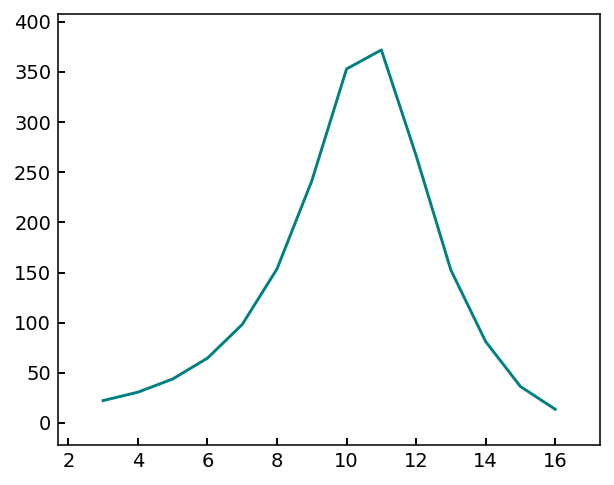

In [20]:
fig, ax = plt.subplots()
ax.plot(xplot, Ne[x,g])

In [10]:
reg["Sd_target_recycle"].values / reg["Sd_target_recycle"].attrs["conversion"]

array([0.25687059, 0.36150367, 0.53727224, 0.83352748, 1.3447967 ,
       2.25057953, 3.8144841 , 6.03377592, 6.41945147, 4.57380226,
       2.52758539, 1.23106485, 0.50239427, 0.17810205])

In [6]:
Ne[x,i]

array([ 31.44287904,  42.94821292,  61.3462085 ,  90.51371093,
       137.09420537, 211.63493272, 323.52685276, 453.73410587,
       468.68388462, 346.41957136, 207.73706156, 111.2351377 ,
        48.52156379,  17.78386761])

# Match target pump

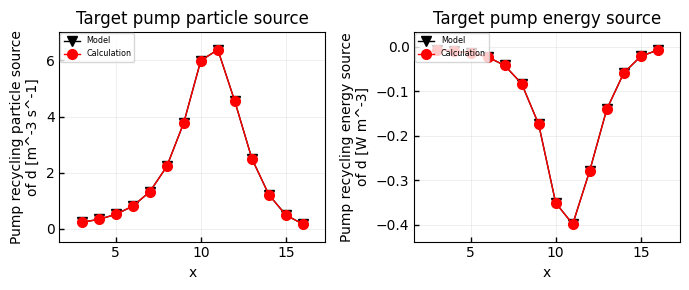

In [16]:
### Neutral impingement
i = -3
g = -2
s = -4

tnguard = Td[x,i]**2 / Td[x,s] 
nnguard = Nd[x,i]**2 / Nd[x,s] 
nnsheath = 0.5 * (Nd[x,i] + nnguard)
tnsheath = 0.5 * (Td[x,i] + tnguard)
v_th = 0.25 * np.sqrt(8 * tnsheath * q_e / (np.pi * Mi))

pump_neutral_particle_flow = v_th * nnsheath * daparsheath
pump_neutral_particle_sink = pump_neutral_particle_flow / dv[x,i] * (1-pump_multiplier)

pump_neutral_energy_flow = 2.0 * tnsheath * v_th * nnsheath * daparsheath 
pump_neutral_energy_sink = pump_neutral_energy_flow / dv[x,i] * (1-pump_multiplier)

### Totals
pump_density_source = recycle_particle_flow/dv[x,i] - pump_neutral_particle_sink
pump_energy_source = recycle_energy_flow/dv[x,i] - pump_neutral_energy_sink

################################################################################
fig, axes = plt.subplots(1,2, figsize=(7,3), dpi = 100)

####################
calc = pump_density_source
####################

ax = axes[0]
style = {"ms" : 7, "lw" : 1}

sim_result = (reg["Sd_pump"] / reg["Sd_pump"].attrs["conversion"])

sim_result.plot(ax = ax, label = "Model", marker = "v", **style, c = "k")
ax.plot(xplot, calc, label = "Calculation", marker = "o", **style, c = "red")
ax.set_title("Target pump particle source")

#####################
calc = pump_energy_source
#####################

ax = axes[1]

sim_result = (reg["Ed_pump"] / reg["Ed_pump"].attrs["conversion"])
sim_result.plot(ax = ax, label = "Model", marker = "v", **style, c = "k",)
ax.plot(xplot, calc, label = "Calculation", marker = "o", **style, c = "red")
ax.set_title("Target pump energy source")

for ax in axes:
    ax.grid()
    ax.legend(loc = "upper left", fontsize = "xx-small")

fig.tight_layout()


In [ ]:
%matplotlib inline

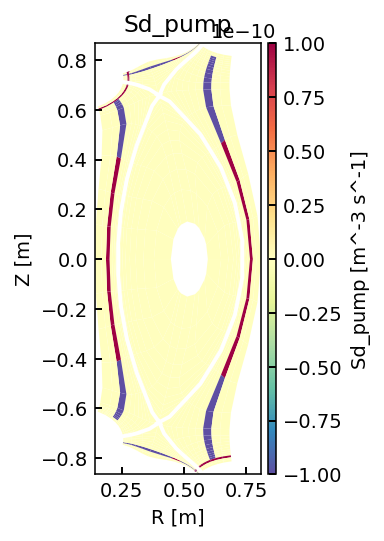

In [ ]:
plt.close("all")
fig, ax = plt.subplots()
# ds["Sd_pump"].hermesm.clean_guards().bout.polygon(ax = ax, cmap = "Spectral_r", antialias = True)
ds["Sd_pump"].bout.polygon(ax = ax, cmap = "Spectral_r", antialias = True, vmin = -1e-10, vmax = 1e-10)

## Trace evolution of the flow diagnostic 

In [ ]:
final_diagnostic = ds["efd+_tot_ylow"].isel(x=x, theta=g) / ds["efd+_tot_ylow"].attrs["conversion"]
sheath_beforesheath = ds["ion_power_ylow_beforesheath"].isel(x=x, theta=g)
sheath_power = ds["sheath_bc_ion_sheath_power_ylow"].isel(x=x, theta=g)


fig, ax = plt.subplots(dpi = 100)
final_diagnostic.plot(ax = ax, label = "evolve pressure diagnostic", marker = "x", **style, c = "blue",)
sheath_beforesheath.plot(ax = ax, label = "sheath: read", marker = "x", **style, c = "orange",)
sheath_power.plot(ax = ax, label = "sheath power add", marker = "x", **style, c = "red",)
debug.plot(ax = ax, label = "recycling read", marker = "v", **style, c = "purple",)
ax.legend()

KeyError: "No variable named 'ion_power_ylow_beforesheath'. Variables on the dataset include ['Bxy', 'Dnnd', 'Ed+_VgradP', 'Ed+_iz', 'Ed+_rec', ..., 'dr', 'hthe', 'dl', 'dtor', 'dpol']"

# Break down into components

In [ ]:
total = ds["efd+_tot_ylow"].isel(x=x, theta=g) / ds["efd+_tot_ylow"].attrs["conversion"]
adv = ds["efd+_adv_ylow"].isel(x=x, theta=g) / ds["efd+_adv_ylow"].attrs["conversion"]
cond = ds["efd+_cond_ylow"].isel(x=x, theta=g) / ds["efd+_cond_ylow"].attrs["conversion"]
before_press = ds["energy_flow_ylow_before_evolpresure"].isel(x=x, theta=g) / ds["energy_flow_ylow_before_evolpresure"].attrs["conversion"]
after_press_add = ds["energy_flow_ylow_after_evolpress_add"].isel(x=x, theta=g) / ds["energy_flow_ylow_after_evolpress_add"].attrs["conversion"]

recycling_read = ds["energy_flow_recycling_read"].isel(x=x, theta=g) / ds["energy_flow_recycling_read"].attrs["conversion"]


fig, ax = plt.subplots(dpi = 100)
total.plot(ax = ax, label = "Evolve pressure total write", marker = "v", **style, c = "blue",)
adv.plot(ax = ax, label = "Evolve pressure advective", marker = "x", **style, c = "orange",)
cond.plot(ax = ax, label = "Evolve pressure conductive", marker = "x", **style, c = "red",)
before_press.plot(ax = ax, label = "Evolve pressure read", marker = "v", **style, c = "purple",)
after_press_add.plot(ax = ax, label = "Evolve pressure after add", marker = "+", **style, c = "green",)
debug.plot(ax = ax, label = "in recycling", marker = "s", **style, c = "black",)

recycling_read.plot(ax = ax, label = "in recycling (read)", marker = "p", **style, c = "deeppink",)
ax.legend()

KeyError: "No variable named 'energy_flow_ylow_before_evolpresure'. Variables on the dataset include ['Bxy', 'Dnnd', 'Ed+_VgradP', 'Ed+_iz', 'Ed+_rec', ..., 'dr', 'hthe', 'dl', 'dtor', 'dpol']"

# Put pump everywhere

In [ ]:
# plt.close("all")

# new_grid_path = r"/home/mike/work/cases/grid_test2_allpump.nc"
# mesh = Mesh(new_grid_path)




# puff = Field("puff", mesh)
# is_pump = Field("is_pump", mesh)

# print()

# is_pump.data[mesh.slices("sol_edge")] = 1
# is_pump.data[mesh.slices("pfr_edge")] = 1
# is_pump.data[mesh.slices("inner_lower_target")] = 1
# is_pump.data[mesh.slices("inner_upper_target")] = 1
# is_pump.data[mesh.slices("outer_upper_target")] = 1
# is_pump.data[mesh.slices("outer_lower_target")] = 1

# is_pump.plot()

# mesh.write_field(is_pump, dtype = "Field2D")

# try:
#     mesh.close()
#     del mesh
# except:
#     pass